 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/3_regression_houseprices.ipynb#Create-model" data-toc-modified-id="Create-model-1">Create model</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/3_regression_houseprices.ipynb#K-fold-validation---manual" data-toc-modified-id="K-fold-validation---manual-2">K-fold validation - manual</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/3_regression_houseprices.ipynb#K-fold-validation---scikit-learn" data-toc-modified-id="K-fold-validation---scikit-learn-3">K-fold validation - scikit-learn</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/3_regression_houseprices.ipynb#Train-final-model" data-toc-modified-id="Train-final-model-4">Train final model</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/3_regression_houseprices.ipynb#References" data-toc-modified-id="References-5">References</a></span></li></ul></div>

# Regression for house price prediction

This is a regression example using the Keras library on the Boston Housing Prices dataset. The model creation is similar as in the previous classification posts, only this time we need to change the loss function and evaluation metrics. Since the dataset is very small with ~400 samples in the training set, I'll do K-fold validation, once by manually splitting the training set into k folds, and once using a more automated approach with the scikit-learn library. The final model is run with the near-optimal number of training epochs and tested on the test set. Parameter optimization is not done in this example.

In [22]:
from keras.datasets import boston_housing

In [23]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


The targets are given in thousands of dollars:

In [24]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

Let's look at one sample. There are 13 features per sample, such as crime rate, number of rooms in the house, house size etc.

In [25]:
train_data[0,:]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

The features are in different ranges, so it's best if we normalize them - subtract the mean and divide with its standard deviation. Now all features will be centered around 0 and have a unit standard deviation. Both training and test sets must be normalized with the same mean and st. deviation values, while the mean and the st. deviation must always be calculated only from the training data, not the test one.

In [26]:
# Find the mean across features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data_norm = train_data - mean
train_data_norm /= std
test_data_norm = test_data - mean
test_data_norm /= std

Here's the first sample of the training set again:

In [28]:
train_data_norm[0,:]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

## Create model

In [29]:
from keras import models
from keras import layers

In [35]:
def create_model():
    model = models.Sequential()
    
    # Add 2 hidden layers
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data_norm.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))

    # Add a linear output layer (without non-linear activation)
    model.add(layers.Dense(1))
    
    # Compile model
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

    return model

## K-fold validation - manual

Because the dataset is very small (only 404 training samples), splitting a separate validation set may not be the best choice - validation scores may have high variance with regard to the validation split.

The better approach in this case is to use K-fold validation - split the training set into k subsets, train a separate model on k-1 sets and evaluate on the k-th set. The validation score at the end is an average over the score of all train-validation combinations across the k subsets. Anyway using a K-fold validation on a big dataset would be very computationally expensive.

In [32]:
import numpy as np

In [45]:
k = 4
num_val_samples = len(train_data_norm) // k
num_epochs = 500
mae_history =[]

for i in range(k):
    print("processing fold #", i)
    
    # Prepare validation data by taking one subset
    val_data = train_data_norm[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare training data using the rest k-1 subsets
    train_data_partial = np.concatenate([train_data_norm[:i * num_val_samples], 
                                        train_data_norm[(i + 1) * num_val_samples:]], axis=0)
    train_targets_partial = np.concatenate([train_targets[:i * num_val_samples], 
                                           train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    # Create a new model for each split
    model = create_model()
    history = model.fit(train_data_partial, train_targets_partial, 
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size=4, verbose=0)
    mae_history.append(history.history['val_mean_absolute_error'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [66]:
# Get the average validation MAE as the mean of mae values at the last epoch
print("Average validation MAE:", np.mean([fold[-1] for fold in mae_history]))
avg_mae_per_epoch = [np.mean(x) for x in zip(*mae_history)]

Average validation MAE: 2.54240617421594


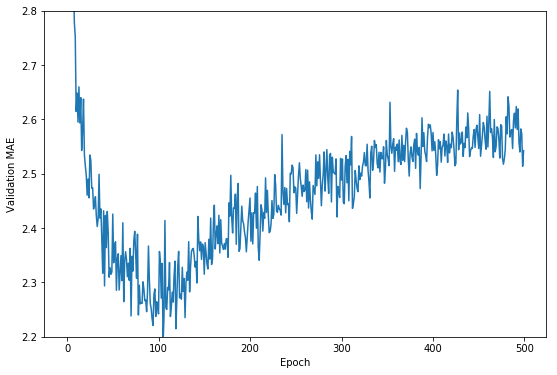

In [76]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9,6)

plt.plot(avg_mae_per_epoch)
plt.ylim([2.2,2.8])
plt.ylabel('Validation MAE')
plt.xlabel('Epoch')
plt.show()

We can see that the validation MAE stops improving around the 100th epoch, after that it starts to overfit.

## K-fold validation - scikit-learn

In the previous section, a big part of the K-fold validation splitting and training was done manually. A bit more automated way is possible using the scikit-learn library as follows.

In [82]:
from sklearn.model_selection import KFold

In [87]:
num_epochs = 500
mae_history =[]
fold_num = 0

# Create cross val. splits and loop through them
kf = KFold(n_splits=4)

for train_index, val_index in kf.split(train_data_norm):
    
    print("processing fold #", fold_num)
    fold_num += 1

    # Create a new model for each split
    model = create_model()
    history = model.fit(train_data_norm[train_index], train_targets[train_index], 
                        validation_data = (train_data_norm[val_index], train_targets[val_index]),
                        epochs=num_epochs, batch_size=4, verbose=0)
    mae_history.append(history.history['val_mean_absolute_error'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


To check if our shortened code does the same thing as above, let's quickly plot the loss again..

Average validation MAE: 2.546585476044381


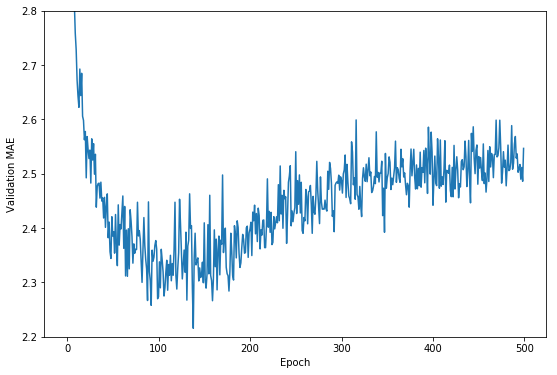

In [88]:
print("Average validation MAE:", np.mean([fold[-1] for fold in mae_history]))
avg_mae_per_epoch = [np.mean(x) for x in zip(*mae_history)]
plt.plot(avg_mae_per_epoch)
plt.ylim([2.2,2.8])
plt.ylabel('Validation MAE')
plt.xlabel('Epoch')
plt.show()

## Train final model

Since the validation showed minimum loss around the 100th epoch, we can train one final model for 100 epochs and test its performance on the test set. I won't do any hyper-parameter optimization in this part.

In [91]:
final_model = create_model()
history = final_model.fit(train_data_norm, train_targets, epochs=100, batch_size=16)
test_results = final_model.evaluate(test_data_norm, test_targets)

Epoch 1/100
404/404 [==============================] - 1s 3ms/step - loss: 523.1017 - mean_absolute_error: 21.0204
Epoch 2/100
404/404 [==============================] - 0s 229us/step - loss: 378.4435 - mean_absolute_error: 17.4319
Epoch 3/100
404/404 [==============================] - 0s 245us/step - loss: 161.6138 - mean_absolute_error: 10.6244
Epoch 4/100
404/404 [==============================] - 0s 263us/step - loss: 54.4422 - mean_absolute_error: 5.6705
Epoch 5/100
404/404 [==============================] - 0s 241us/step - loss: 32.2018 - mean_absolute_error: 4.2204
Epoch 6/100
404/404 [==============================] - ETA: 0s - loss: 25.9484 - mean_absolute_error: 3.63 - 0s 243us/step - loss: 24.3279 - mean_absolute_error: 3.5393
Epoch 7/100
404/404 [==============================] - 0s 267us/step - loss: 20.5352 - mean_absolute_error: 3.1783
Epoch 8/100
404/404 [==============================] - 0s 230us/step - loss: 18.5707 - mean_absolute_error: 2.9817
Epoch 9/100
404/404 [=

In [98]:
print("Loss (MSE): %.3f, MAE: %.3f" % tuple(test_results))

Loss (MSE): 17.580, MAE: 2.618


Since the target prices are in the thousands of dollars, our model on average will miss the target for around $2.6k.

## References
- "Deep Learning with Python" book by Francois Chollet